In [1]:
import collections
import random
from random import  uniform
from math import *
import scipy.optimize as opt
import math 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from copy import copy
import numpy as np
import progressbar
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

def log2(x):
    return log(x,2)

def Hi(v):
    if v==1:
        return 0.5
    return fsolve(lambda x:v -(-x*log2(x)-(1-x)*log2(1-x)),0.0000001)[0]

def H(c):
    """
    Entropy function
    """
    if c == 0. or c == 1.:
        return 0.
    
    if c < 0. or c > 1.:
        return -1000
    
    return -(c * log2(c) + (1 - c) * log2(1 - c))

def binomH(n,k):
    """
    binomial coefficient
    """
    # if k/n not in ZZ:
    #     return -100
    if(n<=0):
        return 0.
    return n * H(k/n)

def wrap(f,g) :
    def inner(x):
        return f(g(*x))
    return inner

def r(x,y,z):
    return [(ru(x,y)) for i in range(z)]

def check_constraints(constraints, solution) : 
    return [ (constraint['type'], constraint['fun'](solution)) for constraint in constraints ]

def validity(mycons, result):
    const= check_constraints(mycons, result)
    for i in const:
        if i[0]=="eq":
            if abs(i[1])>1e-7:
                return False
        elif i[1]<-1e-7:
            return False
    return True

def reps(ell,p_target,p_addends):
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)

# those are set in the loop later, definition here just took make them available
k = lambda x : 0
w = lambda x : 0

# Basic framework

In [2]:
# Defines the value of w to use
# by default we look at full distance decoding
def calc_w(k):
    return Hi(1-k)

In [3]:
set_vars = collections.namedtuple('SievingISD', 'n_ w_ v alpha')
def sieving_isd(f) : return wrap(f, set_vars)

In [4]:
# number of elements on the S_w_^n_ sphere
S = lambda x: binomH(x.n_, x.w_)
# list size
N = lambda x: S(x) - binomH(x.w_, x.w_/2) - binomH(x.n_ - x.w_, x.w_/2)

#success probabilities of ISD procedure
p1 = lambda x: binomH(x.n_,x.w_) + binomH(1 - x.n_, w(x)-x.w_) - binomH(1,w(x))
p2 = lambda x: N(x)-(binomH(x.n_,x.w_)-(x.n_-k(x)))
ISD_prob = lambda x: p1(x)+p2(x) 

def time(x):
    x = set_vars(*x)
    return sieve(x)[0] - ISD_prob(x)

def memory(x):
    x=set_vars(*x)
    return sieve(x)[1]

# constraints to hold, to be read as f(x)>=0
constraints_sieving_ISD = [
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : 1-x.n_)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.n_-x.w_)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : w(x)-x.w_)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : -p2(x))},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : binomH(x.n_,x.w_)-(x.n_-k(x)))},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : N(x))},
]


def set_env(sieve_func, k_in, w_in, constraints, mem=-1):
    """
    Sets global parameters for the sievingISD optimization. Adds memory bound to a returned copy of the constraints area if provided.
     sieve_func  - sieving routine to use
     k,w         - parameters of SD instance
     constraints - set of constraints enforced by the the optimizer
     mem         - memory upper bound for ISD routine
    """
    global k,w,sieve
    k = lambda x: k_in
    w = lambda x: w_in
    sieve = sieve_func
    
    cons = copy(constraints)
    if mem>=0:    
        cons +=[{ 'type' : 'ineq',   'fun' : sieving_isd(lambda x : mem-memory(x))}]
        
    return cons



def optimize_sieving_isd(version,k_in, w_in, mem=-1,iterations=20):
    """
     optimizes time and memory for given sieving function, k, ,w and memory bound
      version     - sieving version to use
      k,w         - parameters of SD instance
      mem         - memory upper bound
      iterations  - number of times the optimizer is run, outputs minimum time found
    """
    # set global parameters and memory bound if provided  
    sieve_func = versions[version]["sieve"]
    constraints = versions[version]["constraints"]
    cons = set_env(sieve_func, k_in, w_in, constraints, mem)
    
    res=1000
    j=0
    
    # run optimizer $iterations$ times but at least as often to obtain runtime<0.12 (prange for FD)
    while j < iterations or res>0.13:
        # choose random starting points
        
        while True:
            n_ = uniform(k_in,k_in+0.009)
            w_ = uniform(0,min(0.009,n_,w([])))
            start=[n_,w_,uniform(0,0.009),uniform(0,0.009)]
            x = set_vars(*start)
            if validity(constraints,x):
                break
        
        # set bounds for variables
        bounds = [(k_in,1)]+[(0,w_in)]+[(0,w_in)]+[(0,1)] 

        # run optimizer
        result = opt.minimize(time, start, 
                bounds = bounds, tol=1e-7, 
                constraints=cons, options={'maxiter':2000})
        r = result.get('fun')
        
        # if successful update result if it provides better time
        if(r < res and result.success):
            res = r
            ress = result
        j+=1
    try:
        return time(ress.x),memory(ress.x)#,ress.x
    except:
        return 0.15,0.15

# Different Sieving routines

In [5]:
# GJN version 1 (Lemma 4.1)
def sieve_gjn(x):
    P = binomH(x.w_,x.w_/2)
    return N(x) + P,N(x) + P

#####################
#### Naive Hash #####
# version 3 (naive hash, not formalized in the paper)
def sieve_hashing_naive(x):
    if x.w_/2-x.v<0:
        return 100,100
    P = binomH(x.w_,x.v)
    D = binomH(x.w_/2,x.v)
    F = binomH(x.n_,x.v)
    return max(N(x) + P,2*(N(x)+P)-D-F), N(x) + P-D


constraints_hashing_naive=constraints_sieving_ISD+[
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.w_/2-x.v)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.n_-x.v)}
    
]
#####################


#####################
#### Coded Hash #####
def prange(k,w):
    """
    return complexity of prange ISD to find all codewords of weight w
    """
    return binomH(1,w)-binomH(1-k,w)

# uses same constraints as naive hash
def sieve_coded_hash(x):
    """
    Coded hash (Theorem 4.3)
    """
    if x.w_ < 1e-10:
        return 0, 0
    
    if x.w_/2-x.v<0:
        return 100,100
    P = binomH(x.w_,x.v)
    D = binomH(x.w_/2,x.v)
    F = binomH(x.n_,x.v)
    p_w = x.v/x.w_
    p_k = (x.w_-D)/x.w_
    return max(N(x)+x.w_*prange(p_k,p_w),N(x) + P - D,2*(N(x)+P)-D-F), N(x) + P-D


def sieve_coded_hash_rep(x):
    """
    Coded hash with repetitions (Corollary 4.1)
    
    >>> alpha = d <<< alpha is used as the reptition parameter to save a variable in the optimization framework
    """
    if x.w_ < 1e-10:
        return 0, 0
    
    if x.w_/2-x.v<0 or x.w_==0 or x.w_-x.alpha<0:
        return 100,100
    P = binomH(x.w_,x.v)
    D = x.alpha
    F = binomH(x.n_,x.v)
    p_w = x.v/x.w_
    p_k = (x.w_-D)/x.w_
    return max(N(x)+x.w_*prange(p_k,p_w),N(x) + P - D,2*(N(x)+P)-D-F)+D-binomH(x.w_/2,x.v), N(x) + P-D


# constraints for coded hash with repetitions version
constraints_coded_hash_rep=constraints_hashing_naive+[
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : binomH(x.w_,x.v)-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.alpha-binomH(x.w_/2,x.v))},
]
    
#####################
    
    
#######################
#### RPC versions #####

def sieve_rpc_v_eq_alpha(x):
    """
    RPC version without memory improvement (Theorem 4.4) with v = alpha
    """
    P = binomH(x.w_,x.v)
    D = binomH(x.w_/2,x.v)
    F = binomH(x.n_,x.v)
    
    return N(x) + P - D + max(0,N(x) + P - F), N(x) + P - D


def cap_vol(n,w,v,alpha):
    """
    Returns size of spherical cap C_{w,v,alpha}^n
    """
    return binomH(w,alpha)+binomH(n-w,v-alpha)

def wedge_vol(x):
    """
    Returns wedge volume W_(w,v,alpha)^n
    """
    def volume(e):
        return binomH(x.w_/2,e) + 2*binomH(x.w_/2,x.alpha-e)+binomH(x.n_-3*x.w_/2,x.v-2*x.alpha+e)
    
    # -volume to find maximum by minimization, max since if e chosen s.t. binomials not well defined results in larger negative number
    def find_e(e):
        return -max(0,volume(e))
    
    e=opt.fminbound(find_e, 0, min(x.w_/2,x.alpha), xtol=1e-10, full_output=1)
    return volume(e[0])


def sieve_rpc(x):
    """
    RPC version without memory improvement (Theorem 4.4)
    """
    if x.v<x.alpha or x.w_<x.alpha or x.n_-x.w_ < (x.v-x.alpha):
        return 100,100
    
    P = cap_vol(x.n_,x.w_,x.v,x.alpha)
    D = wedge_vol(x)
    F = binomH(x.n_,x.v)
    
    return N(x) + P - D + max(0,N(x) + P - F), N(x) + P-D

# optimization constraints for RPC version 
constraints_rpc=constraints_sieving_ISD+[
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.v-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.w_-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_isd(lambda x : x.n_-x.w_ - (x.v-x.alpha))},
]



def sieve_rpc_opt_mem(x):
    """
    RPC version with memory improvement (Corollary 4.2)
    """
    if x.v<x.alpha or x.w_<x.alpha or x.n_-x.w_ < (x.v-x.alpha):
        return 100,100
    
    P = cap_vol(x.n_,x.w_,x.v,x.alpha) 
    D = wedge_vol(x)
    F = binomH(x.n_,x.v)
    
     
    return N(x) + P - D + max(0,N(x) + P - F), N(x)

#######################

### Functions to start optimization for multiple parameters

In [6]:
def plot_for_all_rates(version, mem=-1, iterations=20, L_update=None):
    """
    Returns a list with [Rate, Weight, Time, Memory] for specified version, while enforcing memory bound mem
      version     - sieving version to use
      mem         - memory upper bound
      iterations  - number of times the optimizer is run, outputs minimum time found
      L_update    - list of previous optimization that will be updated only if found optimization yields better value
    """
    L=[]
    bar = progressbar.ProgressBar(maxval=99)
    bar.start()
    for i in range(1,100):
        k = i/100
        w = calc_w(k)
        t,m = optimize_sieving_isd(version=version, k_in=k, w_in=w, mem=mem,iterations=iterations)
        if L_update == None:
            L.append([k,w,t,m])
        elif L_update[i-1][2]>t:
            L_update[i-1][2] = t
            L_update[i-1][3] = m
        bar.update(i)
    
    if L_update == None:
        return L
    return L_update

In [7]:
def plot_tradeoffs(version, k, w,iterations=20, L_update= None):
    """
    Returns a list with [Time, Memory] for increasing memory
      version     - sieving version to use
      mem         - memory upper bound
      iterations  - number of times the optimizer is run, outputs minimum time found
      L_update    - list of previous optimization that will be updated only if found optimization yields better value
    """
    L=[]
    bar = progressbar.ProgressBar(maxval=20)
    bar.start()

    for i in range(20):
        mem = i*0.1/20 if i !=0 else 1e-6
        t,m = optimize_sieving_isd(version=version, k_in=k, w_in=w, mem=mem, iterations=iterations)
        if L_update == None:
            L.append([t,m])
        elif L_update[i][0]>t:
            L_update[i][0] = t
            L_update[i][1] = m
        bar.update(i)
    progressbar.streams.flush()
    if L_update == None:
        return L
    return L_update

In [12]:
versions={"GJN": {"sieve":sieve_gjn, "constraints":constraints_hashing_naive, "it":30, "it_tmto":30},
         #"Hash": {"sieve":sieve_hashing_naive, "constraints":constraints_hashing_naive, "it":130, "it_tmto":30},
         "Coded Hash": {"sieve":sieve_coded_hash, "constraints":constraints_coded_hash_rep, "it":80, "it_tmto":100},
         "Coded Hash Rep": {"sieve":sieve_coded_hash_rep, "constraints":constraints_hashing_naive, "it":25,"it_tmto":100},
         "RPC": {"sieve":sieve_rpc, "constraints":constraints_rpc, "it":25, "it_tmto":100},
         "RPC opt mem": {"sieve":sieve_rpc_opt_mem, "constraints":constraints_rpc, "it":25, "it_tmto":100}
         }



In [9]:
def plot_versions(key):
    """
    plotting function
    """
    plt.rcParams.update({'font.size': 16})
    for i in versions.keys():
        if key == "data":
            Ltime =[[j[0],j[2]] for j in versions[i][key]]
            x,y=zip(*Ltime)
            plt.plot(x,y, label=i)
        else:
            Ltime = versions[i][key]
            x,y=zip(*Ltime)
            plt.plot(x,y, label=i , marker="+")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Compute and Plot Data for Different Rates

In [10]:
# functions to launch computation / update for all rates
def compute_for_all_rates(version):
    return plot_for_all_rates(version, iterations=versions[version]["it"])    
def update_accuracy_for_all_rates(version, iterations=20):
    versions[version]["data"]=plot_for_all_rates(version, iterations=iterations, L_update=versions[version]["data"])

In [ ]:
### Compute optimal time for all versions for all rates
for i in versions.keys():
    versions[i]["data"]=compute_for_all_rates(i)

100% (99 of 99) |########################| Elapsed Time: 0:03:16 ETA:  00:00:00

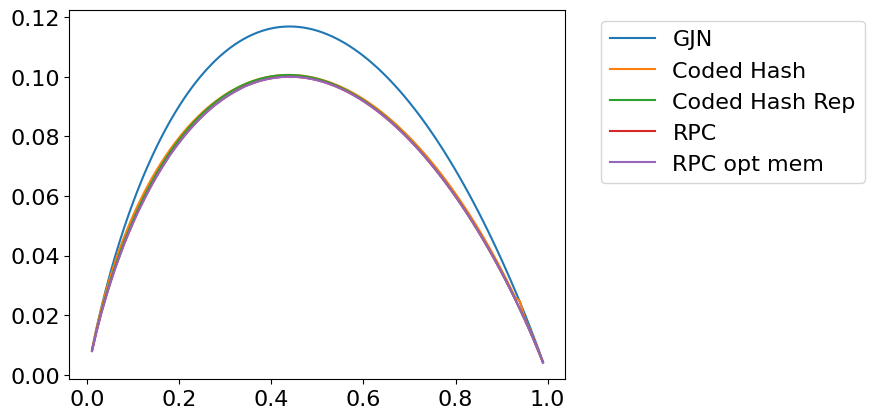

In [19]:
plot_versions("data")

In [ ]:
# RUN ONLY IF PLOTS DO CONTAIN LEAPS
# run this cell as often as needed to increase the accuracy
# you can also run individual updates by calling $update_accuracy_for_all_rates(<version>)$
for i in versions.keys():
    update_accuracy_for_all_rates(i, iterations)

100% (99 of 99) |########################| Elapsed Time: 0:00:37 ETA:  00:00:00

In [21]:
# Print max runtime over all rates 

def round_up(x,d):
    return int(x*10**d+1)/10**d

for i in versions.keys():
    worst= max(versions[i]["data"], key = lambda x: x[2])
    if len(i)>7:
        print(i,"\t&\t",worst[0],"\t&\t",round_up(worst[2],4),"\t&\t",round_up(worst[3],4))
    else:
        print(i,"\t\t&\t",worst[0],"\t&\t",round_up(worst[2],4),"\t&\t",round_up(worst[3],4))

GJN 		&	 0.44 	&	 0.1169 	&	 0.0279
Coded Hash 	&	 0.44 	&	 0.1007 	&	 0.0849
Coded Hash Rep 	&	 0.44 	&	 0.1007 	&	 0.1181
RPC 		&	 0.44 	&	 0.1001 	&	 0.0852
RPC opt mem 	&	 0.44 	&	 0.1001 	&	 0.0633


In [157]:
def prange(k,w):
    return binomH(1,w)-binomH(1-k,w)

In [164]:
# Prange worst case decoding complexity
max([[k/100,prange(k/100,Hi(1-k/100))] for k in range(100)], key= lambda x: x[1])

[0.45, 0.12069561511241295]

### Compute and Plot Time-Memory Trade-Offs

In [23]:
def compute_tmto(version,k):
    return plot_tradeoffs(version,k,calc_w(k), iterations=versions[version]["it_tmto"])

def update_tmto(version,k, iterations=20):
    versions[i]["TMTO"]=plot_tradeoffs(version,k,calc_w(k), iterations=iterations,L_update=versions[i]["TMTO"])


In [24]:
# Compute Time-Memory Trade-Off Curve for all versions

k_value=0.5
for i in versions.keys():
    versions[i]["TMTO"]=compute_tmto(i,k_value)

 95% (19 of 20) |######################  | Elapsed Time: 0:02:49 ETA:   0:00:11

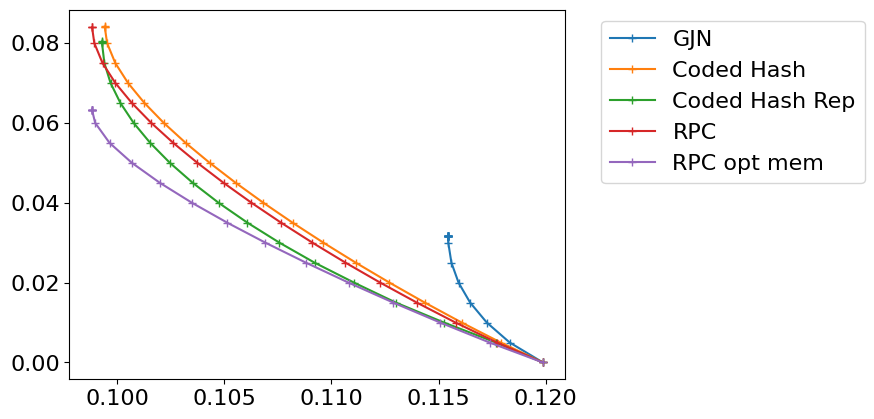

In [25]:
plot_versions("TMTO")


In [ ]:
# RUN ONLY IF ABOVE PLOTS STILL CONTAIN LEAPS
# update to increase accuracy if necessary
for i in versions.keys():
    update_tmto(i,k_value, iterations=5)

# Comparing pure NNS routines

In [26]:
n_=1

### Code to optimize pure NNS routines outside of the Decoding context

In [30]:
def time_rpc_opt(x):
    """ 
    Returns complexity of LSF via RPC for list size N([]) and weight wp([]) (Theorem 4.4)
    """
    a,b=x
    x = set_vars(1,wp_(x),a,b)
    return sieve_rpc_opt_mem(x)[0]

def time_hash(w_):
    """ 
    Returns complexity of LSF via Coded hash function (without repetitions) for list size N([]) and weight wp([]) (Theorem 4.2)
    """    
    def to_optimize(x):
        var = set_vars(1,w_,x,0)
        return sieve_coded_hash(var)[0]
    e=opt.fminbound(to_optimize, 0, w_/2, xtol=1e-10, full_output=1)
    return e[1]

def time_hash_opt(x):
    """ 
    Returns complexity of LSF via Coded hash function with repetitions for list size N([]) and weight wp([]) (Corollary 4.1)
    """    
    a,b=x
    x = set_vars(1,wp_(x),a,b)
    return sieve_coded_hash_rep(x)[0]


## Definition of the optimization framework to numerically optimize the above funcitons (similar to the one from the decoding context)
set_vars_sieve = collections.namedtuple('Sieving', 'v alpha')
def sieving_cons(f) : return wrap(f, set_vars_sieve)

# constraints to hold, to be read as f(x)>=0
constraints_sieve_hash = [
    { 'type' : 'ineq',   'fun' : sieving_cons(lambda x : wp_(x)-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_cons(lambda x : wp_(x)/2-x.v)},
]
constraints_sieve_rpc=[
    { 'type' : 'ineq',   'fun' : sieving_cons(lambda x : x.v-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_cons(lambda x : wp_(x)-x.alpha)},
    { 'type' : 'ineq',   'fun' : sieving_cons(lambda x : 1-wp_(x) - (x.v-x.alpha))},
]


def optimize_sieve(w_,time_sieve,iterations=20,cons=[]):
    """
     optimizes time and memory for given sieving function, k, ,w and memory bound
      version     - sieving version to use
      k,w         - parameters of SD instance
      mem         - memory upper bound
      iterations  - number of times the optimizer is run, outputs minimum time found
    """
    global wp_
    wp_ = lambda x: w_
    # run optimizer $iterations$ times but at least as often to obtain runtime<0.12 (prange for FD)
    j=0
    res=100
    while j < iterations:
        # choose random starting points
        
        while True:
            start=[uniform(0,0.1),uniform(0,0.1)]
            if time_sieve(start)<1:
                break
            
            
        
        bounds = [(0,1)]+[(0,w_)]

        # run optimizer
        result = opt.minimize(time_sieve, start, 
                bounds = bounds, tol=1e-7, 
                constraints=cons, options={'maxiter':2000})
        r = result.get('fun')
        
        # if successful update result if it provides better time
        if(r < res and result.success):
            res = r
            ress = result
        j+=1
    try:
        return time_sieve(ress.x)
    except:
        return 0.15

In [31]:
def expected_solutions(N,n_,w_):
    """
    returns expected amount of solutions 
    w_: weight of vectors
    N: list size
    n_: length of vectors
    """
    
    
    n_w=w_/n_
    n_size=N/n_
    
    n_size = min(n_size,binomH(1,n_w))
    return (2*n_size + binomH(n_w,n_w/2)+binomH(1-n_w,n_w/2)-binomH(1,n_w))*n_


In [32]:
def esser_nn(size,length,w2,w1):
    """
    Computes complexity of w-nearest neighbor algorithm given in https://eprint.iacr.org/2022/1328, code taken from 
    https://github.com/Memphisd/Revisiting-NN-ISD/blob/master/bm_plus_depth_4.py
    
    w1: weight of elements in list
    w2: target difference
    size: list size
    length: length of vectors
    """
    if length<0.0001 or w1<0.000001:
        return 2*size
    
    n_w1=w1/length
    n_w2=w2/length
    n_size=size/length
    
    if size >=binomH(length,w1) or n_w2>2*n_w1*(1-n_w1):
        return 2*size
    lam=min(1/2*(2*n_w1**2 - 2*n_w1 + n_w2)/(n_w1**2 - n_w1), -n_size*log2(2)/log2(2*n_w1**2 - 2*n_w1 + 1))
    
    def time(x):
        return ( binomH(1,n_w2)-binomH(1-x,n_w2)+max(2*n_size+log2(1-n_w1*(1-n_w1)*2)*x,n_size))*length
    mini=time(lam)
    #print(binomH(1,n_w2)-binomH(1-lam,n_w2),2*n_size+log2(1-n_w1*(1-n_w1)*2)*lam,n_size)
    return mini

### Compute NNS complexity for fixed w_ as a function of N

In [40]:
import time
Lgjn=[]
Lsols=[]
Lesser=[]
Lhash=[]
Lhash_opt=[]
Lrpc=[]
Lquadratic=[]
bar = progressbar.ProgressBar(maxval=40)
bar.start()
for i in range(1,41):
    n_=1
    w_=0.02748
    N = lambda x: i/200
    x=set_vars(1,w_,0,0)

    # There must be at least as many vectors of weight w_ as the starting list size
    if binomH(n_,w_)<N(x):
        bar.update(i)
        time.sleep(0.05)
        continue

    Lquadratic.append([N(x),max(expected_solutions(N(x),1,w_),2*N(x))/N(x)])
    Lgjn.append([N(x),max(expected_solutions(N(x),1,w_),sieve_gjn(x)[0])/N(x)])
    Lsols.append([N(x),expected_solutions(N(x),1,w_)/N(x)])
    Lesser.append([N(x),esser_nn(N([]),1,w_,w_)/N(x)])
    Lhash.append([N(x),time_hash(w_)/N(x)])
    Lhash_opt.append([N(x),optimize_sieve(w_,time_hash_opt,iterations=30)/N(x)])
    Lrpc.append([N(x),optimize_sieve(w_,time_rpc_opt,iterations=50, cons=constraints_sieve_rpc)/N(x)])

    bar.update(i)

100% (40 of 40) |########################| Elapsed Time: 0:00:32 ETA:  00:00:00

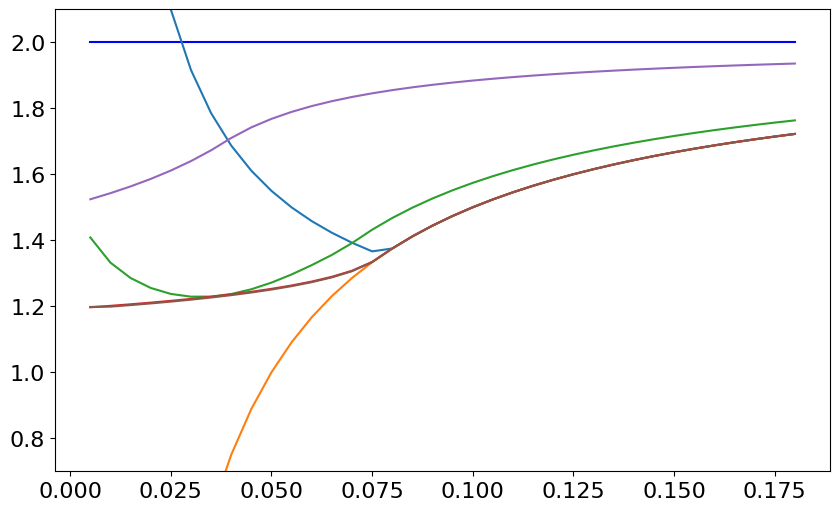

In [41]:
plt.figure(figsize=(10,6))
plt.ylim(0.7,2.1)
x,y=zip(*Lquadratic)
plt.plot(x,y, color="blue")

x,y=zip(*Lgjn)
plt.plot(x,y)

x,y=zip(*Lsols)
plt.plot(x,y)

x,y=zip(*Lhash)
plt.plot(x,y)

x,y=zip(*Lhash_opt)
plt.plot(x,y)

x,y=zip(*Lesser)
plt.plot(x,y)

x,y=zip(*Lrpc)
plt.plot(x,y)

### Compute NNS complexity for fixed N as a function of w

In [48]:
N = lambda x: 0.05

In [53]:
Lgjn=[]
Lsols=[]
Lesser=[]
Lhash=[]
Lhash_opt=[]
Lrpc=[]

steps=100
bar = progressbar.ProgressBar(maxval=steps-1)
bar.start()

for i in range(1,steps):
    w_=i/(2*steps)
    x=set_vars(1,w_,0,0)
    
    # There must be at least as many vectors of weight w_ as the starting list size
    if binomH(n_,w_)<N(x):
        continue
    
    Lgjn.append([w_,max(expected_solutions(N(x),1,w_),sieve_gjn(x)[0])/N(x)])
    Lsols.append([w_,expected_solutions(N(x),1,w_)/N(x)])
    Lesser.append([w_,esser_nn(N([]),1,w_,w_)/N(x)])
    Lhash.append([w_,time_hash(w_)/N(x)])
    Lhash_opt.append([w_,optimize_sieve(w_,time_hash_opt,iterations=30)/N(x)])
    Lrpc.append([w_,optimize_sieve(w_,time_rpc_opt,iterations=50, cons=constraints_sieve_rpc)/N(x)])
    bar.update(i)

100% (99 of 99) |########################| Elapsed Time: 0:01:47 ETA:  00:00:00

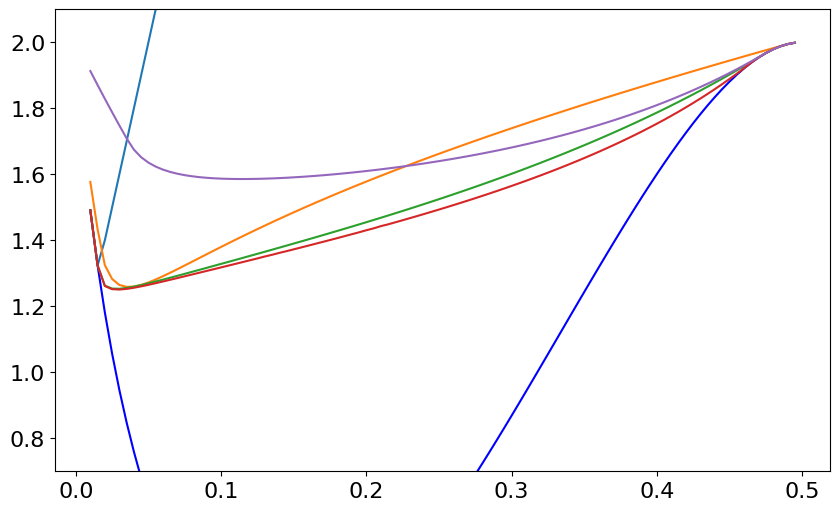

In [54]:
plt.figure(figsize=(10,6))
plt.ylim(0.7,2.1)
x,y=zip(*Lgjn)
plt.plot(x,y)

x,y=zip(*Lsols)
plt.plot(x,y, color="blue")

x,y=zip(*Lhash)
plt.plot(x,y)

x,y=zip(*Lhash_opt)
plt.plot(x,y)

x,y=zip(*Lrpc)
plt.plot(x,y)

x,y=zip(*Lesser)
plt.plot(x,y)


x=[0.02748, 0.02748]
y=[0.02, 0.1]
plt.plot(x,y)

plt.show()